<a href="https://colab.research.google.com/github/kabilank6/Twitter-Sentiment-Analysis/blob/fix-zero-divison-error/Twitter_Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

We first need to ingest the csv file so we can take its information for further processing later on. From inspection, we see that the data is unstructured (that is, not laid out in things like columns - each relevant line/row just represents what is said in a tweet). 

In my view, the best way to take the data in is then to open the csv, then read the csv (like a text file - fortunately Python has a library called "csv" for this purpose), and to append any relevant rows (that is, that has a tweet) to a list which I will call "tweet_list". From this, we have everything we need in one place (the list), and we can do whatever analysis we desire after.

In [11]:
import csv

tweet_list = []

# Can replace "support_tweets.csv" with desired csv filename. The assumption here
# is that the only row that doesn't contain a tweet other than an empty
# row is that which contains the string "tweet_text", like in the csv provided.


with open("support_tweets.csv") as csv_file:
    csv_reader = csv.reader(csv_file)
    line_count = 0
    for row in csv_reader:
      item = "".join(row)
      if item != "" and item != "tweet_text":
        tweet_list.append(item)
print(tweet_list)
print(len(tweet_list))

['@AppleSupport causing the reply to be disregarded and the tapped notification under the keyboard is opened😡😡😡', '@105835 Your business means a lot to us. Please DM your name, zip code and additional details about your concern. ^RR https://t.co/znUu1VJn9r', "@76328 I really hope you all change but I'm sure you won't! Because you don't have to!", '@105836 LiveChat is online at the moment - https://t.co/SY94VtU8Kq or contact 03331 031 031 option 1, 4, 3 (Leave a message) to request a call back', "@VirginTrains see attached error message. I've tried leaving a voicemail several times in the past week https://t.co/NxVZjlYx1k", '@105836 Have you tried from another device, Miriam ^MM', "@VirginTrains yep, I've tried laptop too several times over the past week and again today. I've tried different browsers too", "@105836 It's working OK from here, Miriam. Does this link help https://t.co/0m2mpH15eh ? ^MM", "@VirginTrains I still haven't heard &amp; the number I'm directed to by phone is a dea

As outlined in Task One, we want to extract the sentiment of each tweet. Before going into this however, it is worth breaking down what we can expect from each sentence, so we understand how to deal with each sentence. To achieve this, we can look at examples from the csv file we are given.

'@AppleSupport causing the reply to be disregarded and the tapped notification under the keyboard is opened😡😡😡' is an example.

We can see from this (and cross inspection with other examples) that there are three specific common parts to each tweet. The @ part (for the Twitter handle of someone being mentioned), the message (in this case it's in one sentence, however in others the tweet's message could be covered through at least two sentences). Lastly, in this and several other cases, there often is an emoji included somewhere (in the sentence mentioned above, we can see it is angry). In some tweets, we can see initials of a company representative replying to a query (for example, "RR" in "@105835 Your business means a lot to us. Please DM your name, zip code and additional details about your concern. ^RR https://t.co/znUu1VJn9r"). Due to the limited time of this task, I will assume that this will be treated as neutral (as we intuitively would want to treat it) by any sentiment analysis library we use.

With this in mind, perhaps the only part of the tweet that might be worth giving special treatment to is the emoji. From doing some research, I found [this Stack Overflow post](https://stackoverflow.com/questions/57744725/how-to-convert-emojis-emoticons-to-their-meanings-in-python) that suggested a good way to objectively deal with the emoji is to convert it to a relevant word that describes its sentiment well (our choice of model will handle the rest after with the rest of the text). However, it seems unweldy to copy a lot of code for a few specific emojis, and it would be nice if there was a library that did this for us. Fortunately, [VADER Sentiment Analysis](https://pypi.org/project/vader-sentiment/) seems to be good with dealing with UTF-8 encoded emojis, and social media style sentiment analysis, so it is worth looking into it.

In [12]:
!pip install vaderSentiment

In [13]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()
for sentence in tweet_list:
    vs = analyzer.polarity_scores(sentence)
    print("{:-<65} {}".format(sentence, str(vs)))

@AppleSupport causing the reply to be disregarded and the tapped notification under the keyboard is opened😡😡😡 {'neg': 0.11, 'neu': 0.89, 'pos': 0.0, 'compound': -0.3818}
@105835 Your business means a lot to us. Please DM your name, zip code and additional details about your concern. ^RR https://t.co/znUu1VJn9r {'neg': 0.0, 'neu': 0.901, 'pos': 0.099, 'compound': 0.3182}
@76328 I really hope you all change but I'm sure you won't! Because you don't have to! {'neg': 0.0, 'neu': 0.727, 'pos': 0.273, 'compound': 0.6839}
@105836 LiveChat is online at the moment - https://t.co/SY94VtU8Kq or contact 03331 031 031 option 1, 4, 3 (Leave a message) to request a call back {'neg': 0.046, 'neu': 0.954, 'pos': 0.0, 'compound': -0.0516}
@VirginTrains see attached error message. I've tried leaving a voicemail several times in the past week https://t.co/NxVZjlYx1k {'neg': 0.144, 'neu': 0.856, 'pos': 0.0, 'compound': -0.4019}
@105836 Have you tried from another device, Miriam ^MM----------- {'neg': 0.0, 

From reading the VaderSentiment documentation, for our purposes (classifying sentiment for each whole tweet), we can assess each tweet's compound score (the 'compound' field in the SentimentIntensityAnalyzer). Due to time constraints, I will use this as a proxy for our sentiment classification.

Based off the documentation, a compound score of at least 0.05 is positive, less than this but over -0.05 is neutral, and less than or equal to -0.05 is negative.

With this in mind, I will classify each tweet as such, and subsequently create a pie chart that visualises the proportion of tweets that are considered as positive, neutral and negative.

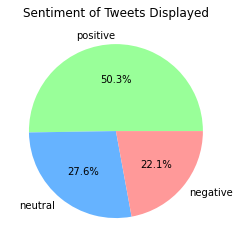

In [14]:
sentiment_dictionary = {"positive": 0, "neutral": 0, "negative": 0}

for sentence in tweet_list:
    vs = analyzer.polarity_scores(sentence)
    compound = vs["compound"]
    if compound >= 0.05:
      sentiment_dictionary["positive"] += 1
    elif compound > -0.05:
      sentiment_dictionary["neutral"] += 1
    else:
      sentiment_dictionary["negative"] += 1

import matplotlib.pyplot as plt
import numpy as np

plot_labels = []
quantities = []
for item in sentiment_dictionary:
  plot_labels.append(item)
  quantity = sentiment_dictionary[item]
  quantities.append(quantity)
quantities = np.array(quantities)
colours = ["#99ff99","#66b3ff", "#ff9999"]
plt.pie(quantities, labels = plot_labels, colors=colours, autopct="%1.1f%%")
plt.title('Sentiment of Tweets Displayed')
plt.show() 

It seems that a slight majority of all our tweets (in the initial dataset at least) are considered as positive by the model. This is interesting, and perhaps we want to investigate how trustworthy these results are. In my view, this would be achieved by inspecting results that are classified as 'positive' individually.

In [15]:
for sentence in tweet_list:
    vs = analyzer.polarity_scores(sentence)
    compound = vs["compound"]
    if compound >= 0.05:
      print("\'{}\' has a compound of {}!".format(sentence, compound))

'@105835 Your business means a lot to us. Please DM your name, zip code and additional details about your concern. ^RR https://t.co/znUu1VJn9r' has a compound of 0.3182!
'@76328 I really hope you all change but I'm sure you won't! Because you don't have to!' has a compound of 0.6839!
'@VirginTrains yep, I've tried laptop too several times over the past week and again today. I've tried different browsers too' has a compound of 0.296!
'@105836 It's working OK from here, Miriam. Does this link help https://t.co/0m2mpH15eh ? ^MM' has a compound of 0.6841!
'@105836 That's what we're here for Miriam 😊  The team should send you an email shortly ^HP' has a compound of 0.7184!
'@105837 We can help. Which version of iOS are you on? You can find that in Settings &gt; General &gt; About. Reply in DM. https://t.co/GDrqU22YpT' has a compound of 0.4019!
'@105838 @AppleSupport Me too am suffering , hope the can find a solution' has a compound of 0.2732!
'@AppleSupport hi #apple, I’ve a concern about t

From my (admittedly subjective) observation, it seems that most of these 'positive' tweets are replies to queries on behalf of a company (perhaps VADER picked up optimistic tones from these via words used politely in this context like 'like', 'help' and 'happy' that tend to be interpreted positively, and this increased their compound scores?). There also tend to be a lot of inclusive pronouns/words like 'we', 'together' and 'our' that may add to this nuance that is interpreted positively by VADER. I also note that positive emojis like ":-)", "🤗" and "😊" (to name a few) come up in these tweets, which likely drives the compound score up as we are told that VADER takes them into account. Otherwise, there are some clear positive tweets here too - such as happy customer reviews. For example, "@AppleSupport Super help - problem solved 😀 once again in love with Apple" and "@AppleSupport Okey. Thank you! 🤗" seem quite positive to me. 

There also are a few exceptions (where would the fun be if there weren't?). For example, "Okay @76099 I used my fucking phone for 2 minutes and it drains it down 8 fucking percent" does not seem positive at all to me (in fact, it clearly seems negative). Perhaps its compound score is relatively high due to the sexual connotations of the "f word" (which can be interpreted in a positive or happy way). Also, "@Uber_Support @115879 wouldn't do this to me 😔" seems like a disappointed tweet, so if this is the case it shouldn't be considered positive. Perhaps in this case, the algorithm is interpreting the sentence as the tweeter speaking positively about @115879, rather than negatively about @Uber_Support. However, from inspection, these seem to be some relatively rare extreme exceptions, but overall most of the positive classifications seem reasonable to me (although I may not fully agree that each of them should be considered positive overall).

While I wouldn't consider seeing if we can adjust the results due to limited time, I think it is worth at least considering that there is an argument that a lot of these more 'nuanced' (that is, using less strong positive words) and less emoji-filled tweets are better placed to be classified as 'neutral' rather than 'positive'. Outside of retraining or changing our model, perhaps we could consider changing the thresholds to deal with these questionable results to fine-tune the model to align with our expectations.

Otherwise, let's consider the other tasks.

To see how many times a specific inputted (lower case - assuming this is the format) word or handle has been seen in all tweets, we can create a specific function for this purpose. The way I would do this is to make a function that inspects each tweet (via the tweets list), and find if that word/handle appears in each tweet (once is sufficient - I think worrying about repetition can bias the integrity of the function's results), and accumulate to a counter it returns at the end if so.

In [16]:
def word_commonality(word):
  word = word.lower()
  count = 0
  for tweet in tweet_list:
    split_tweet = tweet.split()
    for item in split_tweet:
      item = item.lower()
      if item == word:
        count += 1
        break
  return count

Let's run some examples (on our initial data). I will try "thanks" and "@applesupport".

In [17]:
print("The word commonality of \'thanks\' is {}".format(word_commonality("thanks")))
print("The handle commonality of \'@AppleSupport\' is {}".format(word_commonality("@AppleSupport")))

The word commonality of 'thanks' is 14
The handle commonality of '@AppleSupport' is 42


"Thanks" comes up in 14 out of 199 tweets, and "@AppleSupport" in 42 of 199 tweets. This seems reasonable to me.

We want the average sentiment of tweets with a specific word or handle. To do so, we could follow a largely similar method to before (checking each tweet where the handle/word appears). We then would get the sentiment of each relevant tweet (using compound), get the average of this, then scale this between 0 and 100% (0.0 would be a good place for 50%, but 0% should be marked by the lowest possible compound score, and vice versa for 100%). We are told that the compound score is normalised to be between -1 and 1 so I will use these as the relevant benchmarks, and linearly extrapolate between them for simplicity. I will also use 'thanks' and '@AppleSupport' as examples here too.

In [18]:
def average_sentiment(word):
  word = word.lower()
  count = 0
  total_compound = 0
  for tweet in tweet_list:
    split_tweet = tweet.split()
    for item in split_tweet:
      item = item.lower()
      if item == word:
        count += 1
        vs = analyzer.polarity_scores(tweet)
        compound = vs["compound"]
        total_compound += compound
        break
  print(count)
  average_compound = total_compound / count
  fraction = (average_compound + 1) / 2
  return fraction

In [19]:
print("The average sentiment of \'thanks\' is {}%".format(round(100 * average_sentiment("thanks"), 1)))
print("The average sentiment of \'@AppleSupport\' is {}%".format(round(100 * average_sentiment("@AppleSupport"), 1)))

14
The average sentiment of 'thanks' is 82.3%
42
The average sentiment of '@AppleSupport' is 53.4%


The average sentiment of 'thanks' is 82.3% which is quite positive, which intuitively makes sense. For '@AppleSupport' it was 53.4% which is quite neutral. As we saw it come up in positive tweets, it must have come up in (probably some mix of) negative or neutral tweets too for its overall sentiment to be neutral! This makes sense as these tweets are probably complaints which are more negative.


To retrieve the most positive, negative, or divisive (evenly split) words, we need to inspect each word coming from any tweet individually, and carry out an overall sentiment analysis on each word (the average sentiment function from above seems suitable for this task).  

To make this interesting, I could split this up into words and handles. That is, figure out the most positive, negative and divisive word, and likewise for handles!


In [24]:
import string


def sentiment_ranker():
  words_dict = {}
  all_words = []
  for tweet in tweet_list:
    split_tweet = tweet.split()
    for item in split_tweet:
      item = item.lower()
      vs = analyzer.polarity_scores(tweet)
      compound = vs["compound"]
      if item not in words_dict:
        words_dict[item] = [compound, 1]
      else:
        words_dict[item][0] += compound
        words_dict[item][1] += 1
  print(words_dict)
  highest, lowest, middle = float('-inf'), float('inf'), float('inf')
  highest_word, lowest_word, middle_word = '', '', ''
  for word in words_dict:
    item = words_dict[word]
    average_sentiment = item[0]/item[1]
    if average_sentiment > highest:
      highest = average_sentiment
      highest_word = word
    if average_sentiment < lowest:
      lowest = average_sentiment
      lowest_word = word
    if abs(average_sentiment) < abs(middle):
      middle = average_sentiment
      middle_word = word
  print(highest_word, middle_word, lowest_word)

sentiment_ranker()




{'@applesupport': [2.8490999999999995, 42], 'causing': [-0.3818, 1], 'the': [2.0387000000000004, 105], 'reply': [0.010500000000000065, 5], 'to': [24.54800000000001, 86], 'be': [6.481000000000001, 16], 'disregarded': [-0.3818, 1], 'and': [12.766399999999999, 61], 'tapped': [-0.3818, 1], 'notification': [-0.3818, 1], 'under': [-0.4845, 2], 'keyboard': [-0.8585, 2], 'is': [1.5866999999999991, 49], 'opened😡😡😡': [-0.3818, 1], '@105835': [0.3182, 1], 'your': [5.9473, 33], 'business': [0.3182, 1], 'means': [0.8288, 2], 'a': [10.759099999999998, 52], 'lot': [0.22469999999999998, 2], 'us.': [3.3131, 5], 'please': [7.0331, 17], 'dm': [8.9684, 30], 'name,': [1.2207000000000001, 3], 'zip': [0.3182, 1], 'code': [0.9097999999999999, 2], 'additional': [0.3182, 1], 'details': [2.9465000000000003, 6], 'about': [1.5948000000000002, 11], 'concern.': [0.3182, 1], '^rr': [0.3182, 1], 'https://t.co/znuu1vjn9r': [0.3182, 1], '@76328': [0.6839, 1], 'i': [-1.4861, 51], 'really': [0.6839, 1], 'hope': [1.6486, 3

IndexError: ignored